<a href="https://colab.research.google.com/github/dannyyho/Algorithmic-Trader/blob/main/AlgoTrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and Data

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 8.4 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 5.0 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=0b9c60eadecab087f5d829be2dc7fd2eb08ef8d32d8bbfecf632ee3f8fcfb92a
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import plotly.graph_objects as go
import pandas_ta as ta
from plotly.subplots import make_subplots
from datetime import datetime

In [ ]:
# Collect NVIDIA data
symbol='NVDA'
start_date = '2020-01-01'
end_date = '2022-07-09'

nvda = data.DataReader(symbol, 'yahoo', start_date, end_date)
nvda = nvda.reset_index()
nvda.head()

In [ ]:
start_date = '2022-01-01'
end_date = '2022-7-22'

df=yf.download('NVDA', start_date, end_date, interval = '1d')
df.rename(columns = {'Low' : 'low', 'High' : 'high', 'Open' : 'open', 'Close' : 'close'}, inplace = True)
df = df[df['Volume']!=0]
df.reset_index(drop=False, inplace=True)
df.isna().sum()

[*********************100%***********************]  1 of 1 completed


Date         0
open         0
high         0
low          0
close        0
Adj Close    0
Volume       0
dtype: int64

# Relative Strength Index Convergence

In [ ]:

#df.ta.indicators()
#help(ta.rsi)
df['RSI'] = df.ta.rsi(length=14)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       138 non-null    datetime64[ns]
 1   open       138 non-null    float64       
 2   high       138 non-null    float64       
 3   low        138 non-null    float64       
 4   close      138 non-null    float64       
 5   Adj Close  138 non-null    float64       
 6   Volume     138 non-null    int64         
 7   RSI        124 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 8.8 KB


In [ ]:
#@title
dfpl = df[0:137]

fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close']), row=1, col=1)
fig.append_trace(go.Scatter(
    x=dfpl.index,
    y=dfpl['RSI'],
), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
#@title 
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.low[l]>df1.low[i]):
            pividlow=0
        if(df1.high[l]<df1.high[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def RSIpivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0

    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.RSI[l]>df1.RSI[i]):
            pividlow=0
        if(df1.RSI[l]<df1.RSI[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0 

In [ ]:
df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
df['RSIpivot'] = df.apply(lambda x: RSIpivotid(df, x.name, 3, 3), axis=1)

In [ ]:
#@title
def pointpos(x):
    if x['pivot']==1:
        return x['low']-1e-3
    elif x['pivot']==2:
        return x['high']+1e-3
    else:
        return np.nan

def RSIpointpos(x):
    if x['RSIpivot']==1:
        return x['RSI']-1
    elif x['RSIpivot']==2:
        return x['RSI']+1
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
df['RSIpointpos'] = df.apply(lambda row: RSIpointpos(row), axis=1)
df[df.RSIpivot==1].count()

Date           14
open           14
high           14
low            14
close          14
Adj Close      14
Volume         14
RSI            14
pivot          14
RSIpivot       14
pointpos        3
RSIpointpos    14
dtype: int64

In [ ]:
dfpl = df[0:137]
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close']), row=1, col=1)

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=1, col=1)

fig.append_trace(go.Scatter(x=dfpl.index, y=dfpl['RSI']), row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=2, col=1)


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
import numpy as np
from matplotlib import pyplot
backcandles= 30

#candleid = 8800
candleid = 100

maxim = np.array([])
minim = np.array([])
xxmin = np.array([])
xxmax = np.array([])

maximRSI = np.array([])
minimRSI = np.array([])
xxminRSI = np.array([])
xxmaxRSI = np.array([])

for i in range(candleid-backcandles, candleid+1):
    if df.iloc[i].pivot == 1:
        minim = np.append(minim, df.iloc[i].low)
        xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
    if df.iloc[i].pivot == 2:
        maxim = np.append(maxim, df.iloc[i].high)
        xxmax = np.append(xxmax, i) # df.iloc[i].name
    if df.iloc[i].RSIpivot == 1:
        minimRSI = np.append(minimRSI, df.iloc[i].RSI)
        xxminRSI = np.append(xxminRSI, df.iloc[i].name)
    if df.iloc[i].RSIpivot == 2:
        maximRSI = np.append(maximRSI, df.iloc[i].RSI)
        xxmaxRSI = np.append(xxmaxRSI, df.iloc[i].name)
        
slmin, intercmin = np.polyfit(xxmin, minim,1)
slmax, intercmax = np.polyfit(xxmax, maxim,1)
slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)

print(slmin, slmax, slminRSI, slmaxRSI)


dfpl = df[candleid-backcandles-5:candleid+backcandles]
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close']), row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="pivot", row=1, col=1)
fig.add_trace(go.Scatter(x=xxmin, y=slmin*xxmin + intercmin, mode='lines', name='min slope'), row=1, col=1)
fig.add_trace(go.Scatter(x=xxmax, y=slmax*xxmax + intercmax, mode='lines', name='max slope'), row=1, col=1)

fig.append_trace(go.Scatter(x=dfpl.index, y=dfpl['RSI']), row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",
                marker=dict(size=2, color="MediumPurple"),
                name="pivot", row=2, col=1)
fig.add_trace(go.Scatter(x=xxminRSI, y=slminRSI*xxminRSI + intercminRSI, mode='lines', name='min slope'), row=2, col=1)
fig.add_trace(go.Scatter(x=xxmaxRSI, y=slmaxRSI*xxmaxRSI + intercmaxRSI, mode='lines', name='max slope'), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

-1.6125555337811817 -1.9903813915616506 0.37192730783516176 0.15357534289743816


In [ ]:
dfpl = df[0:137]
def divsignal(x, nbackcandles):
    backcandles=nbackcandles 
    candleid = int(x.name)

    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    maximRSI = np.array([])
    minimRSI = np.array([])
    xxminRSI = np.array([])
    xxmaxRSI = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].low)
            xxmin = np.append(xxmin, i) #could be i instead df.iloc[i].name
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].high)
            xxmax = np.append(xxmax, i) # df.iloc[i].name
        if df.iloc[i].RSIpivot == 1:
            minimRSI = np.append(minimRSI, df.iloc[i].RSI)
            xxminRSI = np.append(xxminRSI, df.iloc[i].name)
        if df.iloc[i].RSIpivot == 2:
            maximRSI = np.append(maximRSI, df.iloc[i].RSI)
            xxmaxRSI = np.append(xxmaxRSI, df.iloc[i].name)

    if maxim.size<2 or minim.size<2 or maximRSI.size<2 or minimRSI.size<2:
        return 0
    
    slmin, intercmin = np.polyfit(xxmin, minim,1)
    slmax, intercmax = np.polyfit(xxmax, maxim,1)
    slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
    slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)
    
    
    if slmin > 1e-4 and slmax > 1e-4 and slmaxRSI <-0.1:
        return 0
    elif slmin < -1e-4 and slmax < -1e-4 and slminRSI > 0.1:
        return 1
    else:
        return 0

dfpl['divSignal'] = dfpl.apply(lambda row: divsignal(row,30), axis=1)
dfpl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,Date,high,low,open,close,Volume,Adj Close,RSI,pivot,RSIpivot,pointpos,RSIpointpos,divSignal
0,0,2020-01-02,59.977501,59.180000,59.687500,59.977501,23753600.0,59.803612,NaN,0,0,NaN,NaN,0
1,1,2020-01-03,59.457500,58.525002,58.775002,59.017502,20538400.0,58.846394,NaN,0,0,NaN,NaN,0
2,2,2020-01-06,59.317501,57.817501,58.080002,59.264999,26263600.0,59.093178,NaN,0,0,NaN,NaN,0
3,3,2020-01-07,60.442501,59.097500,59.549999,59.982498,31485600.0,59.808594,NaN,0,3,NaN,NaN,0
4,4,2020-01-08,60.509998,59.537498,59.939999,60.095001,27710800.0,59.920773,NaN,0,3,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2020-07-13,107.922501,100.250000,105.949997,100.522499,45707600.0,100.336777,61.710572,2,0,107.923501,NaN,0
133,133,2020-07-14,104.027496,97.855003,100.750000,103.769997,54267600.0,103.578278,66.083952,1,0,97.854003,NaN,0
134,134,2020-07-15,104.330002,100.557503,104.142502,102.272499,40398400.0,102.083534,62.536830,0,0,NaN,NaN,0
135,135,2020-07-16,102.067497,98.955002,100.150002,101.347504,34496400.0,101.160255,60.380884,0,1,NaN,59.380884,0


In [ ]:
#Backtesting
#PnL: initially we invest $1000
initial_capital= float(1000.0)

positions = pd.DataFrame(index=dfpl.index).fillna(0.0)
portfolio = pd.DataFrame(index=dfpl.index).fillna(0.0)

positions = dfpl['divSignal']
portfolio['positions'] = (positions.multiply(dfpl['close'], axis=0))
portfolio['cash'] = initial_capital - (positions.diff().multiply(dfpl['close'], axis=0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']

portfolio[:2000]

KeyError: ignored

# Bollinger Bands

In [ ]:
def bollinger_bands(nvda, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (nvda['High'] + nvda['Low'] + nvda['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    nvda = nvda.join(B_MA)
    nvda = nvda.join(BU)
    nvda = nvda.join(BL)
    
    return nvda

In [ ]:
n = 20   # datapoint rolling window
m = 2    # sigma width
nvda = bollinger_bands(nvda, 20, 2)

NameError: ignored

In [ ]:
print(nvda.head())
print(nvda.tail())

In [ ]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(nvda['Date'], nvda['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(symbol))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(symbol))
plt.plot(nvda['Date'], nvda['Adj Close'])
plt.plot(nvda['Date'], nvda['BU'], alpha=0.3)
plt.plot(nvda['Date'], nvda['BL'], alpha=0.3)
plt.plot(nvda['Date'], nvda['B_MA'], alpha=0.3)
plt.fill_between(nvda['Date'], nvda['BU'], nvda['BL'], color='grey', alpha=0.1)

plt.show()

In [ ]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
nvda.set_index('Date', inplace=True)
nvda_agg = nvda.resample('W').agg(agg_dict)
nvda_agg = nvda_agg.reset_index()

In [ ]:
# add BB columns
n = 20   # datapoint rolling window
m = 2    # sigma width
nvda_agg = bollinger_bands(nvda_agg, 20, 2)

In [ ]:
def add_signal(nvda):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(nvda['Close'])):
        #if nvda['Close'][i] > nvda['BU'][i]:           # sell signal     daily
        if nvda['High'][i] > nvda['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(nvda['Close'][i])
        #elif nvda['Close'][i] < nvda['BL'][i]:         # buy signal      daily
        elif nvda['Low'][i] < nvda['BL'][i]:            # buy signal      weekly
            buy_list.append(nvda['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    nvda = nvda.join(buy_list)
    nvda = nvda.join(sell_list)        
     
    return nvda

In [ ]:
def plot_signals(nvda, symbol):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(nvda['Date'], nvda['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(symbol))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(symbol))
    plt.plot(nvda['Date'], nvda['Adj Close'], label='Adj Close')

    plt.plot(nvda['Date'], nvda['High'], label='High', alpha=0.3)
    plt.plot(nvda['Date'], nvda['Low'], label='Low', alpha=0.3)

    plt.plot(nvda['Date'], nvda['BU'], label='B_Upper', alpha=0.3)
    plt.plot(nvda['Date'], nvda['BL'], label='B_Lower', alpha=0.3)
    plt.plot(nvda['Date'], nvda['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(nvda['Date'], nvda['BU'], nvda['BL'], color='grey', alpha=0.1)

    plt.scatter(nvda['Date'], nvda['Buy'], label='Buy', marker='^')
    plt.scatter(nvda['Date'], nvda['Sell'], label='Sell', marker='v')

    plt.legend()

    plt.show()

In [ ]:
nvda_agg = add_signal(nvda_agg)
plot_signals(nvda_agg, symbol)

# Volume Trading

In [ ]:
nvdavt = nvda.copy(deep=True)
#OBV
OBV = []
OBV.append(0)
for i in range(1, len(nvda.Close)):
    if nvda.Close[i] > nvda.Close[i-1]: #If the closing price is above the prior close price 
          OBV.append(OBV[-1] + nvda.Volume[i]) #then: Current OBV = Previous OBV + Current Volume
    elif nvda.Close[i] < nvda.Close[i-1]:
          OBV.append( OBV[-1] - nvda.Volume[i])
    else:
          OBV.append(OBV[-1])

nvdavt['OBV'] = OBV

In [ ]:
#EMA
nvdavt['OBV_EMA'] = nvdavt['OBV'].ewm(com=50).mean()

In [ ]:
from numpy.ma.core import set_fill_value
#Create signal

nvdavt["buy"] = np.nan
nvdavt["sell"] = np.nan


flag=0

for i in range(0,len(nvdavt)):
  if nvdavt['OBV'][i]>nvdavt['OBV_EMA'][i] and flag !=1:
    nvdavt['sell'][i]='sell'
    flag=1
  elif nvdavt['OBV'][i]<nvdavt['OBV_EMA'][i] and flag !=-1:
    nvdavt['buy'][i]='buy'
    flag=-1
  else:
    nvdavt["buy"][i] = np.nan
    nvdavt["sell"][i] = np.nan

#nvdavt["buyorsell"] = np.nan

#for i in range(0,len(nvdavt)):
#  if nvdavt["buy"][i]=='buy':
#    nvdavt["buyorsell"][i]='Buy'
#  elif nvdavt["sell"][i]=='sell':
#    nvdavt["buyorsell"][i]='Sell'
#  else:
#    nvdavt["buyorsell"][i]=np.nan

#nvdavt.drop(['sell','buy'], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is 

In [ ]:
#plot

#fig = go.Figure(data=[go.Candlestick(x=nvdavt['Date'],
#                open=nvdavt['Open'], high=nvdavt['High'],
#                low=nvdavt['Low'], close=nvdavt['Close'])
#                     ])

#fig.update_layout(xaxis_rangeslider_visible=False)
#fig.show()
#nvdavt['OBV'].plot(label='OBV',figsize=(15,7))
#fig = make_subplots(specs=[[{"secondary_y": True}]])

fig=go.Figure(
    [go.Scatter(
        x=nvdavt["Date"],
        y=nvdavt["OBV"],
        mode='lines'
        ),
     go.Scatter(
        x=nvdavt["Date"],
        y=nvdavt["OBV_EMA"],
        mode='lines'
        ),

     go.Candlestick(x=nvdavt['Date'],
                    open=nvdavt['Open'], high=nvdavt['High'],
                    low=nvdavt['Low'], close=nvdavt['Close']),
     ]
     ).update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [ ]:
#candlestick
fig2 = go.Figure(data=[go.Candlestick(x=nvdavt['Date'],
                open=nvdavt['Open'], high=nvdavt['High'],
                low=nvdavt['Low'], close=nvdavt['Close'])
                     ])
fig.update_layout(xaxis_rangeslider_visible=False)
fig2.show()

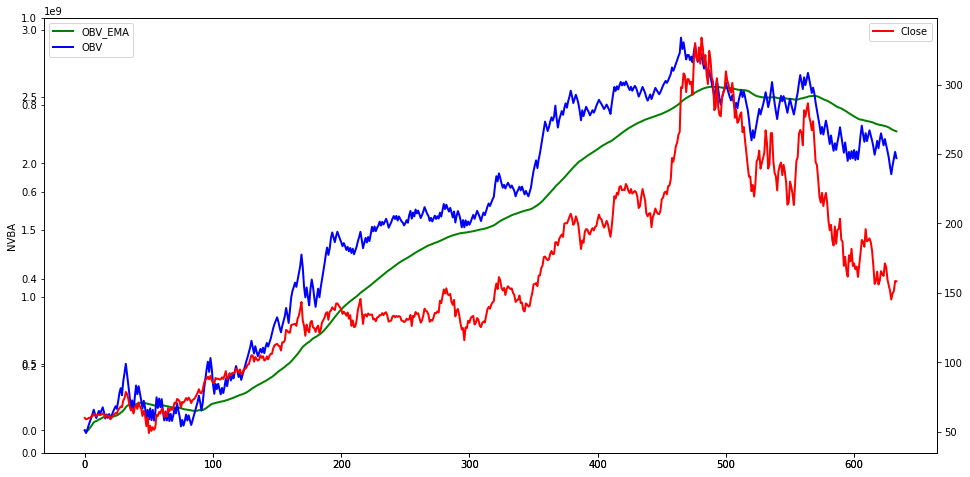

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
 
ax1 = fig.add_subplot(111, ylabel='NVBA')
go.Figure(data=[go.Candlestick(x=nvdavt['Date'],
              open=nvdavt['Open'], high=nvdavt['High'],
              low=nvdavt['Low'], close=nvdavt['Close'])
                     ])
nvdavt['OBV_EMA'].plot(ax=ax1, color='g', lw=2., legend=True)
nvdavt['OBV'].plot(ax=ax1, color='b', lw=2., legend=True) 
plt.legend(loc='upper left') 
ax2 = ax.twinx()
nvdavt['Close'].plot(ax=ax2, color='r', lw=2., legend=True)
plt.legend(loc='upper right') 
plt.show()

# Dual Moving Average